In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops, perimeter

import math

import sys
sys.path.append('../../util')
from curvature import *

In [14]:
#Read Data
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/' #Path for Daint
d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [15]:
#Create a binary mask based on median(FMSE). Separate into wet and dry regions
bFMSE = np.zeros(np.shape(d2D.FMSE), dtype=bool)
for t in range(len(d2D.FMSE[:])):
    fld = d2D.FMSE[t,:,:]
    bFMSE[t,:,:] = np.where(fld > np.percentile(fld, 50, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)

/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


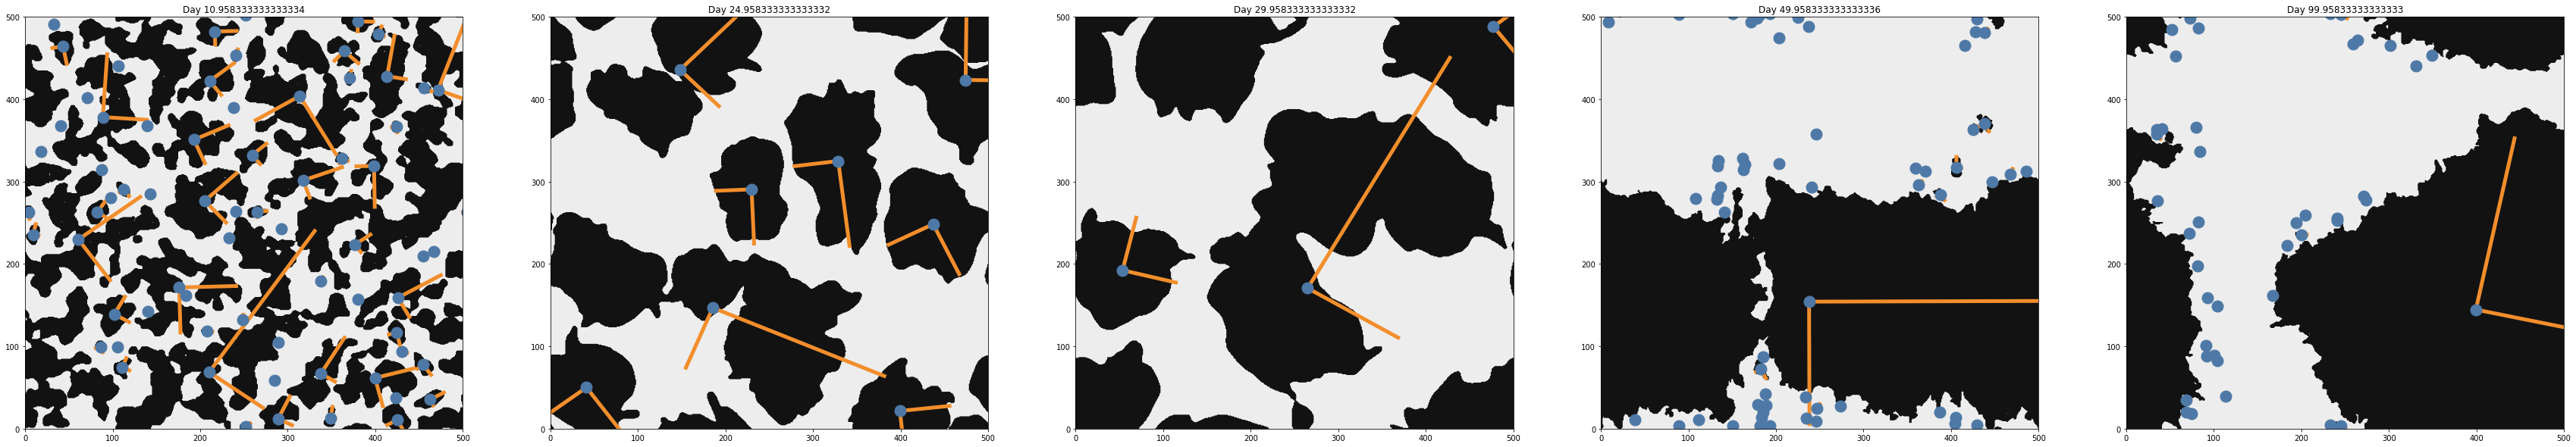

In [23]:
#Options
NrPanels = 10
nb = 3        #Nuber of Boundary Points (e.g. nboundlines form the cosmo namelist)
nt, xn, yn = np.shape(bFMSE)


#Domain of the analysis region in the tiled field
xl  = np.floor_divide(xn, 2)
xr  = np.floor(3/2 * xn).astype(int)

yl  = np.floor_divide(yn, 2)
yr  = np.floor(3/2 * yn).astype(int)

plt.figure(figsize=(60, 10))
nr = 1
#for t in range(0,np.shape(bFMSE)[0],  np.floor_divide(nt, NrPanels)):
pl = np.array([11,25,30,50,100]) * 24 -1
for t in pl:
    
    tiled_bFMSE = np.tile(bFMSE[t,nb:-nb,nb:-nb],(2,2))
    
#    plt.subplot(1, NrPanels, t/np.floor_divide(np.shape(bFMSE)[0], NrPanels)+1)
    plt.subplot(1, 5, nr)
    nr += 1
    plt.contourf(tiled_bFMSE[xl:xr,yl:yr], cmap = 'binary')
    plt.title('Day '+str(t/24))

    labels = label(tiled_bFMSE[:,:], neighbors=8)
    props = regionprops(labels)
    
    for p in range(len(props)):
        y0, x0 = props[p].centroid
        
         #Skip allobjects who's centroid is not in the untiled domain
        if  x0 < xl or x0 > xr:
            continue
        
        if  y0 < yl or y0 > yr:
            continue
                
        y0, x0 = props[p].centroid - xl
        x1 = x0 + math.cos(props[p].orientation) * 0.5 * props[p].major_axis_length
        y1 = y0 - math.sin(props[p].orientation) * 0.5 * props[p].major_axis_length
        x2 = x0 - math.sin(props[p].orientation) * 0.5 * props[p].minor_axis_length
        y2 = y0 - math.cos(props[p].orientation) * 0.5 * props[p].minor_axis_length

        plt.plot((x0, x1), (y0, y1), color='#F28E2B', linewidth=5)
        plt.plot((x0, x2), (y0, y2), color='#F28E2B', linewidth=5)
        plt.plot(x0, y0, marker='.', color='#4E79A7', markersize=30)
        
        plt.xlim((0,500))
        plt.ylim((0,500))

plt.savefig('blobs.pdf')

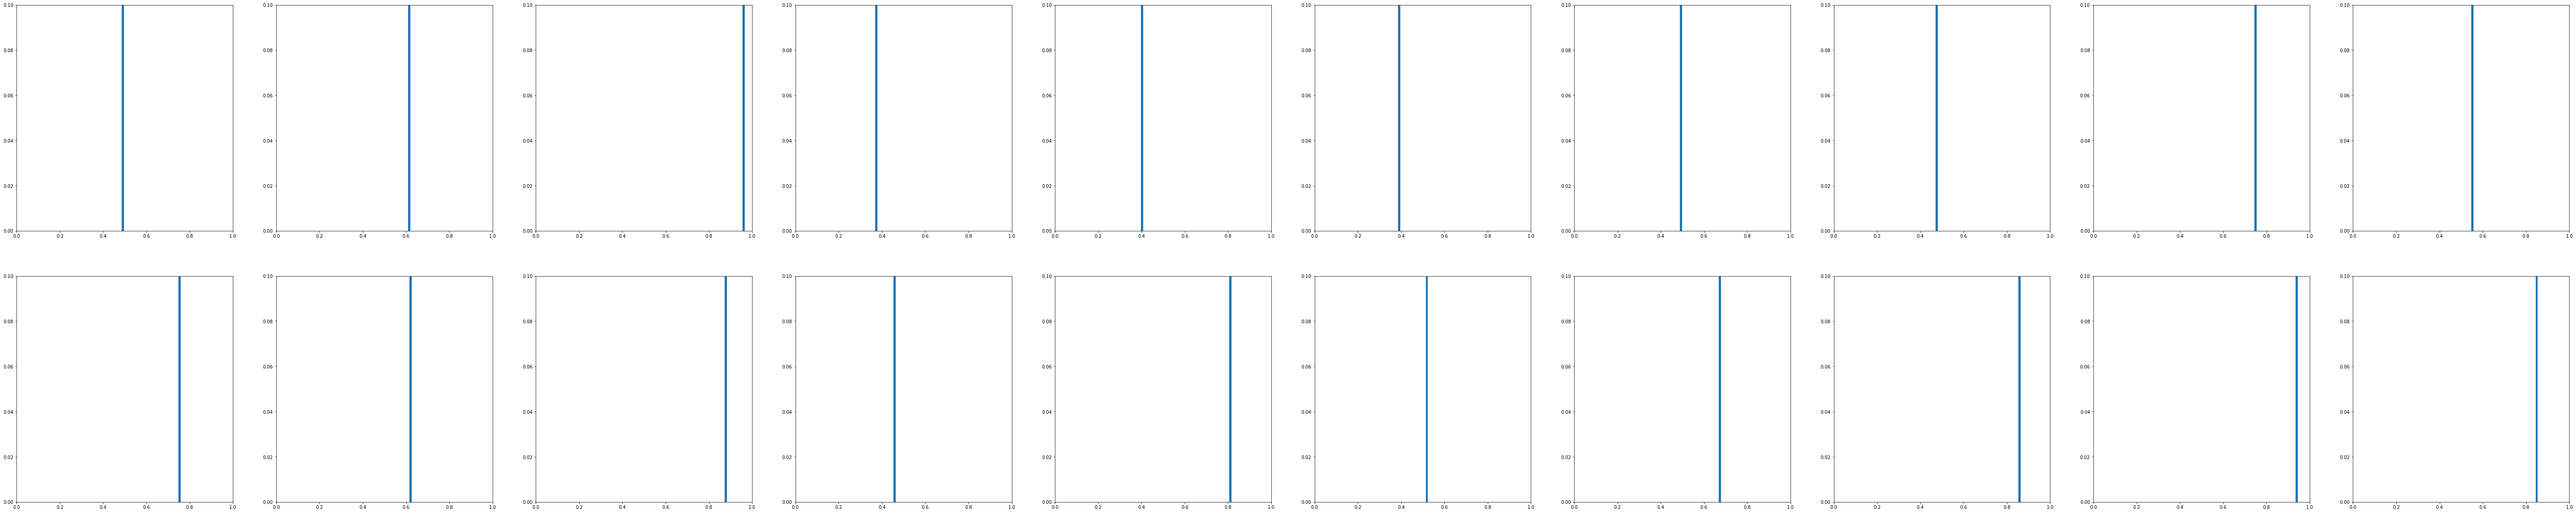

In [5]:
### Eccentricity

#Options
NrPanels = 20
nb = 3        #Nuber of Boundary Points (e.g. nboundlines form the cosmo namelist)
lobj = 1 

nt = np.shape(bFMSE)[0]
xn = np.shape(bFMSE)[1]
yn = np.shape(bFMSE)[2]

#Init arrays
alpha = np.zeros(nt, dtype=float)
perimeter = np.zeros(nt, dtype=float)
a = np.zeros(nt, dtype=float) #Ellipsoid axis
b = np.zeros(nt, dtype=float)

#Domain of the analysis region in the tiled field
xl  = np.floor_divide(xn, 2)
yl  = np.floor_divide(yn, 2)
xr  = np.floor(3/2 * xn)
yr  = np.floor(3/2 * yn)
              
plt.figure(figsize=(NrPanels * 10 / 2, 20))

for t in range(0,nt,  np.floor_divide(np.shape(bFMSE)[0], NrPanels)):
#for t in range(nt):
     
    #To take care of the periodic domain the domain is copied four times.
    tiled_bFMSE = np.tile(bFMSE[t,nb:-nb,nb:-nb],(2,2))

    labels = label(tiled_bFMSE, neighbors=8)
    props = regionprops(labels)
    
    alpha_p = np.array([])
    perimeter_p = np.array([])
    a_p = np.array([])
    b_p = np.array([])

    #Find the 5 biggest objects
    area = np.array([])
    ind = np.array([], dtype=int)
    for p in range(len(props)):
        
        y0, x0 = props[p].centroid - xl
        
         #Skip allobjects who's centroid is not in the untiled domain
        if  x0 < xl or x0 > xr :
            continue
        
        if  y0 < yl+ nb or y0 > yr:
            continue

        area = np.append(area, props[p].area)
        ind = np.append(ind, p)
    
    for p in ind[np.argpartition(area, -lobj)[-lobj:]]:
               
        alpha_p = np.append(alpha_p, props[p].minor_axis_length / props[p].major_axis_length)
        perimeter_p = np.append(perimeter_p, props[p].perimeter)
        a_p = np.append(a_p, props[p].major_axis_length)
        b_p = np.append(b_p, props[p].minor_axis_length)

    alpha[t] = np.percentile(alpha_p, 50, interpolation='linear')
    perimeter[t] = np.sum(perimeter_p)
    a[t] = np.sum(a_p)
    b[t] = np.sum(b_p)

    #Plot histogram of ratio of principal axis
    if np.mod(t, np.floor_divide(np.shape(bFMSE)[0], NrPanels)) == 0:
        weights = np.ones_like(alpha_p)/float(len(alpha_p))
        plt.subplot(2, NrPanels/2, t/np.floor_divide(np.shape(bFMSE)[0], NrPanels)+1)
        plt.hist(alpha_p, bins=100, weights=weights)
        plt.xlim(0, 1)
        plt.ylim(0, 0.1)


Text(0, 0.5, 'perimeter')

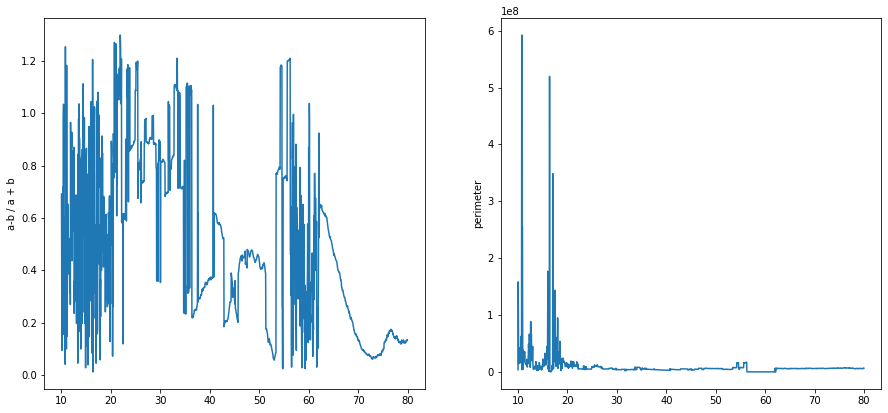

In [6]:

alpha, perim a, b = eccentricity(bFMSE, lobj = 1)
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.plot(np.arange(len(a)) / 24 + 10, 2*(a-b)/(a+b))
#plt.plot(np.arange(len(alpha)) / 24 + 10 , alpha)
plt.ylabel('a-b / a + b')

plt.subplot(2,2,2)
plt.plot(np.arange(len(perim)) / 24 + 10 , perim * 3300)
plt.ylabel('perimeter')


In [ ]:
### Compute Index for all Temperatures

path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/' #Path for Daint
d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

alpha = np.zeros((len(d2D.FMSE[:]),11), dtype='float32')
perim = np.zeros((len(d2D.FMSE[:]),11), dtype='float32')
a = np.zeros((len(d2D.FMSE[:]),11), dtype='float32')
b = np.zeros((len(d2D.FMSE[:]),11), dtype='float32')

for TTT in np.arange(295,306):
    print(TTT)
    #Read Data
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
    d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

    #Create a binary mask based on median(FMSE). Separate into wet and dry regions
    bFMSE = np.zeros(np.shape(d2D.FMSE), dtype=bool)
    for t in range(len(d2D.FMSE[:])):
        fld = d2D.FMSE[t,:,:]
        bFMSE[t,:,:] = np.where(fld > np.percentile(fld, 50, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)

    alpha_T, perimeter_T, a_T, b_T = eccentricity(bFMSE, lobj = 1)
    
    #Bug here
    alpha[:,TTT-295] = alpha_T
    perim[:,TTT-295] = perimeter_T
    a[:,TTT-295] = a_T
    b[:,TTT-295] = b_T

In [ ]:
plt.figure(figsize=(15, 7.5))

plt.subplot(1,2,1)
dx= 3.3
plt.plot(np.arange(len(perim)) / 24 , np.mean(perim*dx,axis=1), color='k')
plt.fill_between(np.arange(len(perim)) / 24 , np.mean(perim*dx,axis=1) + np.std(perim*dx,axis=1), np.mean(perim*dx,axis=1) - np.std(perim*dx,axis=1), alpha=0.3, color='k', linewidth=0.0)
plt.ylabel('perimeter [10^3 km]')
plt.xlabel('day')

plt.yscale('log')
plt.ylim(12**3, 12**5)
plt.xlim((0,100))

plt.subplot(1,2,2)
plt.plot(np.arange(len(a)) / 24, np.mean((a-b)/(a+b), axis=1), color='k')
plt.fill_between(np.arange(len(a)) / 24, np.mean((a-b)/(a+b), axis=1) + np.std((a-b)/(a+b), axis=1), np.mean((a-b)/(a+b), axis=1) - np.std((a-b)/(a+b), axis=1), alpha=0.3, color='k', linewidth=0.0)
#plt.plot(np.arange(len(alpha)) / 24 + 10 , alpha)
plt.ylabel('(a - b) / a + b')
plt.xlabel('day')
plt.xlim((0,100))


plt.savefig('ellipsoid.pdf')


In [ ]:
def calc_WMI(CRH, dx = 3.3e3, nb = 3):
    ### Input: precipitable water field (x, y)
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    
    
    binary = np.where(CRH > np.percentile(CRH, 50, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)
    A_tot = np.sum(binary)*(dx**2)
    
    WMI = 4*np.pi*A_tot/(dx*perimeter(binary))**2
    
    return WMI

In [ ]:
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/' #Path for Daint
d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

MMI = np.zeros((len(d2D.FMSE[:]),11), dtype='float32') #Moisture Meandering Index
iqr = np.zeros((len(d2D.FMSE[:]),11), dtype='float32') #Interquartile range

for TTT in np.arange(295,306):
    print(TTT)
    #Read Data
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
    d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )


    for t in range(len(d2D.FMSE[:,:,:])):
        iqr[t,TTT-295] = np.percentile(d2D.FMSE[t,:,:], 75, interpolation='linear',  axis=(0,1)) - np.percentile(d2D.FMSE[t,:,:], 25, interpolation='linear',  axis=(0,1))
        MMI[t,TTT-295] = calc_WMI(d2D.FMSE[t,:,:])
    

In [ ]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    """source https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin """
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)


plt.figure()

fig, ax1  = plt.subplots()
plt.xlim((0,100))
fig.set_figheight(5)
fig.set_figwidth(5)

ax1.set_ylabel('IQR of FMSE') 
ax1.plot(np.arange(len(iqr)) / 24, np.mean(iqr,axis=1), color='#')
ax1.fill_between(np.arange(len(iqr)) / 24, np.mean(iqr, axis=1) + np.std(iqr, axis=1), np.mean(iqr, axis=1) - np.std(iqr, axis=1), alpha=0.3, color='red', linewidth=0.0)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(np.arange(len(MMI)) / 24, np.mean(MMI,axis=1), color='k',)
ax2.fill_between(np.arange(len(MMI)) / 24, np.mean(MMI, axis=1) + np.std(MMI, axis=1), np.mean(MMI, axis=1) - np.std(MMI, axis=1), alpha=0.3, color='k', linewidth=0.0)
ax2.set_ylabel('MMI') 
ax2.set_ylim((0, 0.3))

align_yaxis(ax1, 0, ax2, 0)
 
plt.savefig('WMI_RCE.pdf')